In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import hydra

def load_sim_mat_cali(config_path:str="../config", config_name:str="main")->dict:
    """Load the similarity matrix for calibration."""
    with hydra.initialize(version_base=None, config_path=config_path):
        cfg = hydra.compose(config_name=config_name)
        cfg_dataset = cfg["KITTI"]
        return joblib.load(
                Path(
                    cfg_dataset.paths.save_path,
                    f"sim_mat_cali_{cfg_dataset.retrieval_dim}_{cfg_dataset.mask_ratio}.pkl",
                )
                )

def overlap_ratio(hist1:np.ndarray, hist2:np.ndarray)->float:
    """Computes the overlap ratio between two histograms."""
    minima = np.minimum(hist1, hist2)
    intersection = np.sum(minima)
    union = np.sum(hist1) + np.sum(hist2) - intersection
    return intersection / union

def get_scores_and_gt(data: dict, idx_modal1: int, idx_modal2: int) -> tuple[list[float], list[float]]:
    """Get the scores and ground truth for the given modalities."""
    scores = []
    gt = []
    for mat, label in data.values():
        scores.append(mat[idx_modal1][idx_modal2])
        gt.append(label)
    return scores, gt

IMAGE = 0
LIDAR = 1
TEXT = 2

bin_edges = np.array(range(51))/25-1
modalities = ["Image", "Lidar", "Text"]

data = load_sim_mat_cali()

### Calibration (2 stages)

In [8]:
from mmda.utils.spearman_utils import spearman_rank_coefficient
from mmda.utils.calibrate import (
    get_calibration_scores_1st_stage, get_calibration_scores_2nd_stage, calibrate, con_mat_calibrate,
)

scores3x3 = {}
for i in range(3):
    for j in range(3):
        scores, _ = get_calibration_scores_1st_stage(data, i, j, skip_same=True)
        scores3x3[(i, j)] = scores

con_mat = con_mat_calibrate(data, scores3x3)
scores, gt = get_calibration_scores_2nd_stage(con_mat, np.mean, skip_same=True)
print(len(scores))
cali_scores = []
for score in scores:
    cali_scores.append(calibrate(score, scores))


Calculating conformal probabilities: 100%|██████████| 602253/602253 [00:10<00:00, 55579.21it/s]


601156


In [9]:
print(cali_scores[0:10])
print(gt[0:10])
print((max(cali_scores), min(cali_scores)))
print(sum(gt)/len(gt), sum(cali_scores)/len(cali_scores))
print(data[(1778, 1778)])
print(con_mat[(1778, 1778)])

[0.0, 0.0, 3.3269234607988607e-06, 4.990385191198291e-06, 6.6538469215977215e-06, 8.317308651997153e-06, 9.980770382396582e-06, 1.1644232112796013e-05, 1.3307693843195443e-05, 1.4971155573594874e-05]
[0 0 0 0 0 0 0 0 0 0]
(0.9999983365382696, 0.0)
0.00627956803225785 0.4999985666590154
(array([[1.        , 1.        , 0.65612533],
       [1.        , 1.        , 0.64953191],
       [0.66635313, 0.64417239, 1.        ]]), 1)
(array([[0.99999834, 0.99999834, 0.9774418 ],
       [0.99999834, 0.99999834, 0.97142505],
       [0.9733397 , 0.97350105, 0.99945937]]), 1)


0.4999985666590167


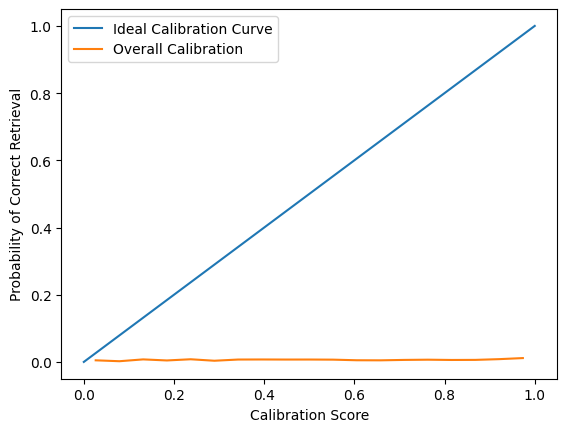

[]

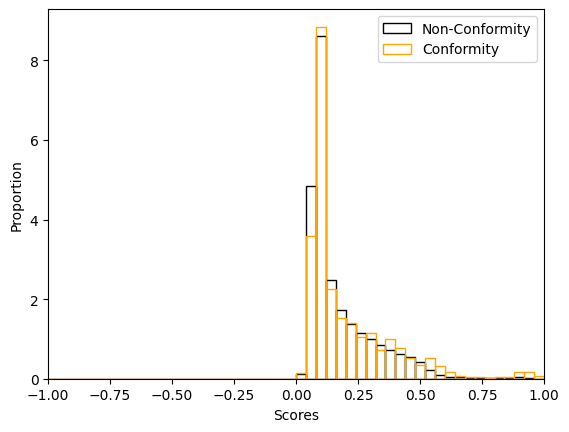

In [10]:
nc_scores = np.array(scores)[gt == 0]
c_scores = np.array(scores)[gt == 1]

print(np.mean(cali_scores))
bins = np.linspace(0, 1, 20)
bin_indices = np.digitize(cali_scores, bins)
bin_scores = []
bin_gt = []
for k in range(1, len(bins)):
    bin_mask = bin_indices == k
    bin_scores.append(np.mean(np.array(cali_scores)[bin_mask]))
    bin_gt.append(np.mean(np.array(gt)[bin_mask]))
plt.figure()
plt.plot([0,1], [0,1], label="Ideal Calibration Curve")
plt.plot(bin_scores, bin_gt, label="Overall Calibration")
plt.xlabel("Calibration Score")
plt.ylabel("Probability of Correct Retrieval")
plt.legend()
plt.show()

plt.figure()
nc_fig = plt.hist(nc_scores, bins=bin_edges, fill=None, edgecolor="black", density=True, label="Non-Conformity")
c_fig = plt.hist(c_scores, bins=bin_edges, fill=None, edgecolor="orange", density=True, label="Conformity")
plt.xlabel("Scores")
plt.ylabel("Proportion")
plt.xlim(-1,1)
plt.legend()
plt.plot()

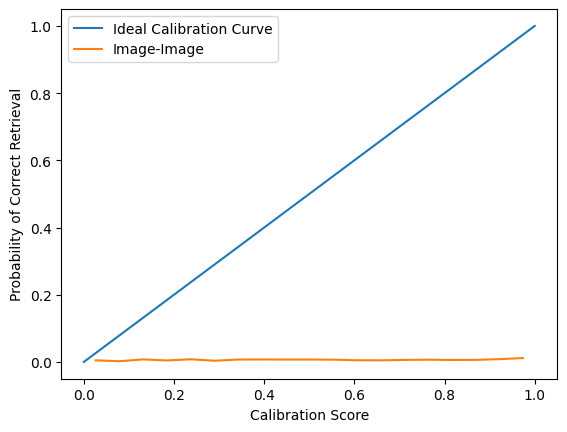

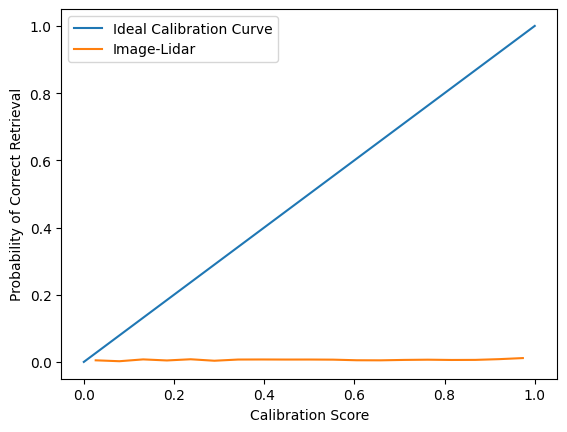

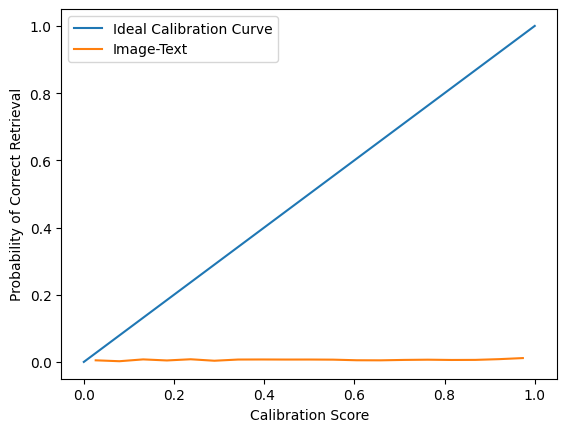

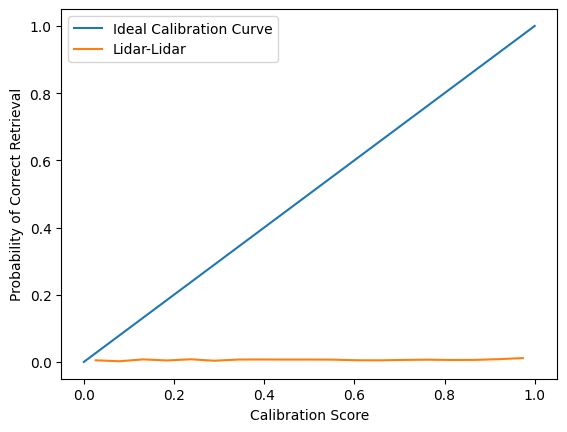

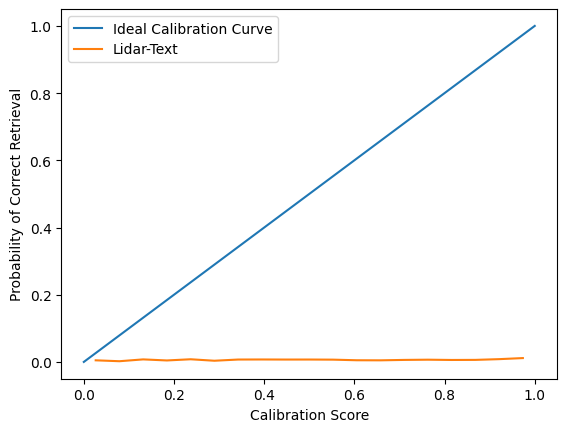

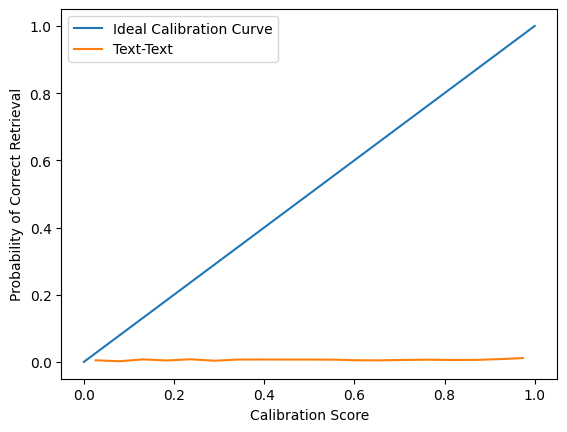

In [12]:
# plot the calibration curve
# x axis: calibration score
# y axis: percentage of data points in the bin
for i in range(3):
    for j in range(i, 3):
        scores, gt = get_calibration_scores_1st_stage(data, i, j, skip_same=True)
        cali_scores = []
        for score in scores:
            cali_scores.append(calibrate(score, scores))

        # combine score to bins and gt to bins
        bins = np.linspace(0, 1, 20)
        bin_indices = np.digitize(cali_scores, bins)
        bin_scores = []
        bin_gt = []
        for k in range(1, len(bins)):
            bin_mask = bin_indices == k
            bin_scores.append(np.mean(np.array(cali_scores)[bin_mask]))
            bin_gt.append(np.mean(np.array(gt)[bin_mask]))
        plt.figure()
        plt.plot([0,1], [0,1], label="Ideal Calibration Curve")
        plt.plot(bin_scores, bin_gt, label=modalities[i] + "-" + modalities[j])
        plt.xlabel("Calibration Score")
        plt.ylabel("Probability of Correct Retrieval")
        plt.legend()
        plt.show()

### Nonconformity distributions

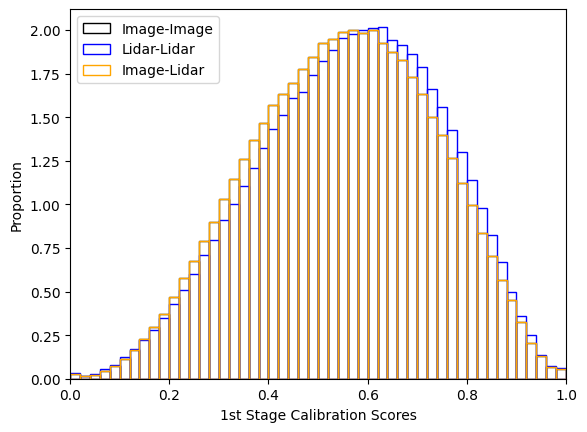

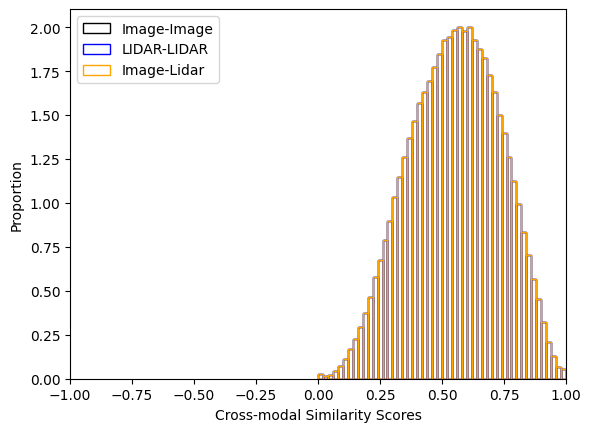

In [32]:
scores_0, _ = get_calibration_scores_1st_stage(data, IMAGE, IMAGE, skip_same=True)
plt.hist(scores_0, bins=50, fill=None, edgecolor="black", density=True, label="Image-Image")
scores_1, _ = get_calibration_scores_1st_stage(data, LIDAR, LIDAR, skip_same=True)
plt.hist(scores_1, bins=50, fill=None, edgecolor="blue", density=True, label = "Lidar-Lidar")
scores, _ = get_calibration_scores_1st_stage(data, IMAGE, LIDAR, skip_same=True)
plt.hist(scores, bins=50, fill=None, edgecolor="orange", density=True, label = "Image-Lidar")

plt.xlabel("1st Stage Calibration Scores")
plt.ylabel("Proportion")
plt.xlim(0, 1)
plt.legend()
plt.show()

score, _ = get_scores_and_gt(data, IMAGE, IMAGE)
plt.hist(scores_0, bins=50, fill=None, edgecolor="black", density=True, label="Image-Image")
score, _ = get_scores_and_gt(data, LIDAR, LIDAR)
plt.hist(scores_0, bins=50, fill=None, edgecolor="blue", density=True, label="LIDAR-LIDAR")
score, _ = get_scores_and_gt(data, IMAGE, LIDAR)
plt.hist(scores_0, bins=50, fill=None, edgecolor="orange", density=True, label="Image-Lidar")

plt.xlabel("Cross-modal Similarity Scores")
plt.ylabel("Proportion")
plt.xlim(-1, 1)
plt.legend()
plt.show()

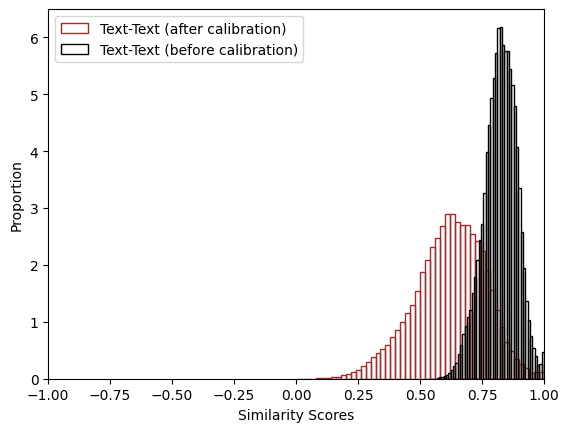

In [33]:
scores_22, _ = get_calibration_scores_1st_stage(data, TEXT, TEXT, skip_same=True)
plt.hist(scores_22, bins=50, fill=None, edgecolor="brown", density=True, label = "Text-Text (after calibration)")
scores_22, _ = get_scores_and_gt(data, TEXT, TEXT)
plt.hist(scores_22, bins=50, fill=None, edgecolor="black", density=True, label = "Text-Text (before calibration)")
plt.xlabel("Similarity Scores")
plt.ylabel("Proportion")
plt.xlim(-1, 1)
plt.legend()

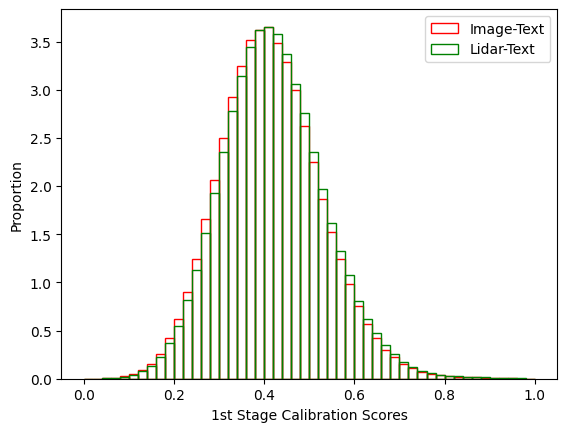

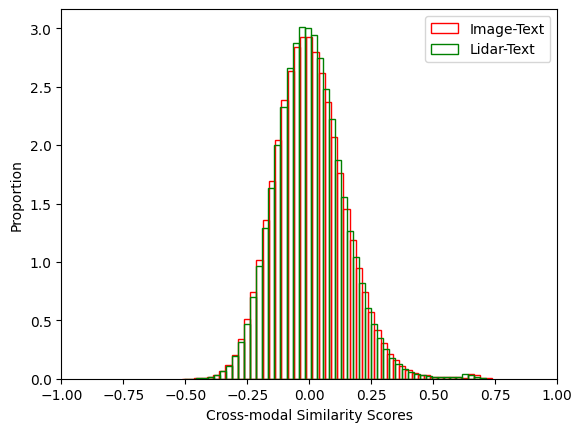

In [34]:
scores_33, _ = get_calibration_scores_1st_stage(data, IMAGE, TEXT, skip_same=True)
plt.hist(scores_33, bins=50, fill=None, edgecolor="red", density=True, label="Image-Text")
scores_44, _ = get_calibration_scores_1st_stage(data, LIDAR, TEXT, skip_same=True)
plt.hist(scores_44, bins=50, fill=None, edgecolor="green", density=True, label="Lidar-Text")

plt.xlabel("1st Stage Calibration Scores")
plt.ylabel("Proportion")
plt.legend()
plt.show()

scores_33, _ = get_scores_and_gt(data, IMAGE, TEXT)
plt.hist(scores_33, bins=50, fill=None, edgecolor="red", density=True, label="Image-Text")
scores_44, _ = get_scores_and_gt(data, LIDAR, TEXT)
plt.hist(scores_44, bins=50, fill=None, edgecolor="green", density=True, label="Lidar-Text")

plt.xlabel("Cross-modal Similarity Scores")
plt.ylabel("Proportion")
plt.xlim(-1, 1)
plt.legend()
plt.show()

In [35]:
def correlation(data: dict, modalities1: tuple[int, int] = (0, 0), modalities2: tuple[int, int] = (1, 1)) -> np.ndarray:
    """Compute the correlation between two modalities."""
    m1, m2 = [], []
    for k in data:
        mat, label = data[k]
        m1.append(mat[modalities1[0]][modalities1[1]])
        m2.append(mat[modalities2[0]][modalities2[1]])
    return np.corrcoef(m1, m2)

modalities = ["Image", "Lidar", "Text"]

for i in range(3):
    for j in range(i, 3):
        for k in range(j, 3):
            for l in range(k, 3): # noqa: E741
                corr = correlation(data, modalities1=(i,j), modalities2=(k,l))[0][1]
                print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", corr)
                scores = [data[_][0][i][j] for _ in data]
                scores_k = [data[_][0][k][l] for _ in data]
                r, _, _ = spearman_rank_coefficient(np.array(scores), np.array(scores_k))
                print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", r)

Image - Image   Image - Image   1.0
Image - Image   Image - Image   1.0
Image - Image   Image - Lidar   1.0
Image - Image   Image - Lidar   1.0
Image - Image   Image - Text   0.2731147057940943
Image - Image   Image - Text   0.001027929727521415
Image - Image   Lidar - Lidar   0.9269552957308141
Image - Image   Lidar - Lidar   0.0019789154056800706
Image - Image   Lidar - Text   0.2736252330370401
Image - Image   Lidar - Text   0.0011037552434068898
Image - Image   Text - Text   0.07818552545478845
Image - Image   Text - Text   0.0010282489961052077
Image - Lidar   Lidar - Lidar   0.9269552957308141
Image - Lidar   Lidar - Lidar   0.0019789154056800706
Image - Lidar   Lidar - Text   0.2736252330370401
Image - Lidar   Lidar - Text   0.0011037552434068898
Image - Lidar   Text - Text   0.07818552545478845
Image - Lidar   Text - Text   0.0010282489961052077
Image - Text   Text - Text   0.13367893664646693
Image - Text   Text - Text   -0.0002955706965110938
Lidar - Lidar   Lidar - Lidar   1